this code is about the classification of the chest CT images into one of the four cancerous conditions namely adenocarcinoma, large cell carcinoma, squamous cell carcinoma and normal.

In [1]:
import numpy as np
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7
# from google.colab import drive
# drive.mount('/content/gdrive')
import scipy
print('done')

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
done


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [21]:
path = '.'
img_size = 224
print(img_size)

224


In [22]:
# !unzip Data.zip
!ls

/bin/bash: switchml: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `switchml'
/bin/bash: _moduleraw: line 1: syntax error: unexpected end of file
/bin/bash: error importing function definition for `_moduleraw'
B7_layeredLearningRate.ipynb  README		       plots
Data			      __MACOSX		       src
Data.zip		      anaconda3		       tools
LICENSE			      examples		       tutorials
Nvidia_Cloud_EULA.pdf	      nvidia-acknowledgements


In [23]:
train_datagen = image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
val_datagen= image.ImageDataGenerator(    
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
test_datagen= image.ImageDataGenerator(    
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [24]:
train_generator = train_datagen.flow_from_directory(
    f'{path}/Data/train',
    target_size = (img_size,img_size),
    batch_size = 16,
    shuffle=True,
    class_mode = 'categorical')
    
validation_generator = val_datagen.flow_from_directory()

test_generator = test_datagen.flow_from_directory()

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [25]:
print('hi')

hi


I have developed a transfer learning based EfficientNetB3 model that has been trained on imagenet dataset. I have added some additional layers to the basic model.

In [26]:
#base_model = EfficientNetB7(weights='imagenet', classifier_activation="softmax", include_top=False)
base_model = EfficientNetB7(input_shape=(224,224,3), weights='imagenet', classifier_activation="softmax", include_top=False)

print(len(base_model.layers))
# print("Layers:", base_model.layers)
lr = 0.1
lr_mult = 0.9

parameters = []

i = 0
for layer in base_model.layers:
    layer.trainable=True

model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D(name="gap"))

model.add(Dense(4, activation='softmax'))
model.summary()


#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              #metrics=['accuracy','AUC','Precision','Recall'])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=False)
optimizers = [tf.keras.optimizers.Adam(learning_rate = lr_schedule), tf.keras.optimizers.Adam(learning_rate = 0.0001)]
optimizers_and_layers = [(optimizers[0], model.layers[0]), (optimizers[1], model.layers[1:])]

model.compile(loss='categorical_crossentropy',
              optimizer=tfa.optimizers.MultiOptimizer(optimizers_and_layers),
              metrics=['accuracy','AUC','Precision','Recall'])
              
#model.compile(loss='categorical_crossentropy',
              #optimizer=tf.keras.optimizers.Adam(learning_rate = lr_schedule),
              #metrics=['accuracy','AUC','Precision','Recall'])

813
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional)  (None, 7, 7, 2560)       64097687  
                                                                 
 gap (GlobalMaxPooling2D)    (None, 2560)              0         
                                                                 
 dense_3 (Dense)             (None, 4)                 10244     
                                                                 
Total params: 64,107,931
Trainable params: 63,797,204
Non-trainable params: 310,727
_________________________________________________________________


In [27]:
base_model.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization_3 (Normalization  (None, 224, 224, 3)  7          ['rescaling_3[0][0]']            
 )                                                                                                
                                                                                     

In [28]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
)

Epoch 1/30
39/39 [==============================] - 149s 1s/step - loss: 1.6279 - accuracy: 0.4894 - auc: 0.7411 - precision: 0.5075 - recall: 0.4437 - val_loss: 2.1287 - val_accuracy: 0.4028 - val_auc: 0.6350 - val_precision: 0.3750 - val_recall: 0.3333
Epoch 2/30
39/39 [==============================] - 38s 968ms/step - loss: 0.7483 - accuracy: 0.7129 - auc: 0.9121 - precision: 0.7428 - recall: 0.6737 - val_loss: 1.3905 - val_accuracy: 0.4167 - val_auc: 0.7166 - val_precision: 0.4407 - val_recall: 0.3611
Epoch 3/30
39/39 [==============================] - 39s 988ms/step - loss: 0.4200 - accuracy: 0.8320 - auc: 0.9690 - precision: 0.8593 - recall: 0.8173 - val_loss: 1.2698 - val_accuracy: 0.5139 - val_auc: 0.7923 - val_precision: 0.5410 - val_recall: 0.4583
Epoch 4/30
39/39 [==============================] - 39s 1s/step - loss: 0.3362 - accuracy: 0.8842 - auc: 0.9803 - precision: 0.8876 - recall: 0.8760 - val_loss: 1.1354 - val_accuracy: 0.5833 - val_auc: 0.8217 - val_precision: 0.619

In [29]:
print(history.history.keys())
h = history.history
print(h['val_accuracy'])

dict_keys(['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall'])
[0.4027777910232544, 0.4166666567325592, 0.5138888955116272, 0.5833333134651184, 0.5555555820465088, 0.6805555820465088, 0.625, 0.6944444179534912, 0.7222222089767456, 0.7638888955116272, 0.7777777910232544, 0.7222222089767456, 0.8194444179534912, 0.8055555820465088, 0.8888888955116272, 0.8472222089767456, 0.8472222089767456, 0.9027777910232544, 0.9027777910232544, 0.9166666865348816, 0.8888888955116272, 0.7916666865348816, 0.8888888955116272, 0.8333333134651184, 0.8888888955116272, 0.8194444179534912, 0.875, 0.9027777910232544, 0.8888888955116272, 0.9444444179534912]


['loss', 'accuracy', 'auc', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_auc', 'val_precision', 'val_recall']
loss loss val_loss


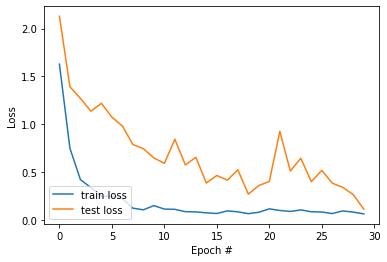

accuracy accuracy val_accuracy


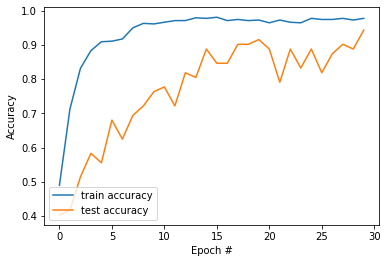

precision auc val_auc


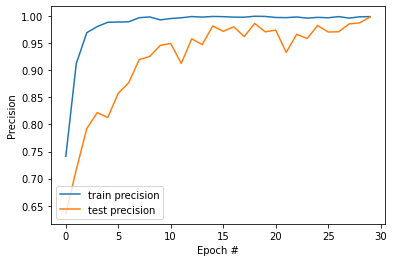

recall recall val_recall


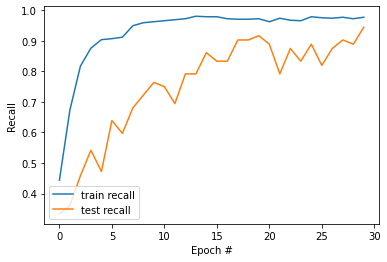

<Figure size 432x288 with 0 Axes>

In [30]:
hdict = history.history
keys = list(hdict.keys())
print(keys)
def graph(name, index):
    print(name, keys[index], keys[(len(keys) // 2) + index])
    train_metric, test_metric = hdict[keys[index]], hdict[keys[(len(keys) // 2) + index]]
    epochs = len(train_metric)
    x = list(range(epochs))

    plt.plot(x, train_metric, label=f'train {name}')
    plt.plot(x, test_metric, label=f'test {name}')

    plt.xlabel('Epoch #')
    plt.ylabel(name.capitalize())
    plt.legend(loc='lower left')
    plt.savefig(f'./plots/{name}.png')
    plt.show()
    plt.clf()

graph('loss', 0)
graph('accuracy', 1)
graph('precision', 2)
graph('recall', 4)

In [31]:
model.evaluate(train_generator)

39/39 [==============================] - 8s 190ms/step - loss: 0.0430 - accuracy: 0.9886 - auc: 0.9977 - precision: 0.9886 - recall: 0.9886


[0.043042462319135666,
 0.9885807633399963,
 0.997687816619873,
 0.9885807633399963,
 0.9885807633399963]

In [32]:
model.evaluate(validation_generator)


72/72 [==============================] - 3s 45ms/step - loss: 0.2491 - accuracy: 0.9444 - auc: 0.9860 - precision: 0.9437 - recall: 0.9306


[0.24912269413471222,
 0.9444444179534912,
 0.986014723777771,
 0.9436619877815247,
 0.9305555820465088]

In [33]:
model.evaluate(test_generator)
# loss, 'accuracy','AUC','Precision','Recall'

315/315 [==============================] - 14s 45ms/step - loss: 0.3933 - accuracy: 0.9111 - auc: 0.9832 - precision: 0.9105 - recall: 0.9048


[0.3932845890522003,
 0.9111111164093018,
 0.9832249879837036,
 0.9105431437492371,
 0.9047619104385376]

In [34]:
tf.keras.models.save_model(model,'B7run0')

INFO:tensorflow:Assets written to: B7run0/assets


/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/home/ubuntu/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
